**Proyecto de ETL y análisis de empresas del S&P 500. Fase 5: clusterización**

In [1]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

**CARGAR Y PREPROCESAR LOS DATOS**

2.1. Cargar el dataset en el cuaderno:

In [3]:
df = pd.read_csv('closing-price-sp-500.csv')
df.head()

,Date,Symbol,Close
0,2024-01-02,A,138.750000
1,2024-01-03,A,131.160004
2,2024-01-04,A,131.000000
3,2024-01-05,A,130.559998
4,2024-01-08,A,133.380005


2.2. Verificar, ordenar y limpiar los datos:

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by = ['Symbol', 'Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60636 entries, 0 to 60635
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    60636 non-null  datetime64[ns]
 1   Symbol  60636 non-null  object        
 2   Close   60636 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.4+ MB


**CÁLCULO DE RETORNOS PORCENTUALES DIARIOS**

3.1. Calcular los retornos porcuentuales diarios:

In [5]:
retornos = df[['Symbol', 'Close']]
retornos = retornos.set_index('Symbol')
retornos['Return'] = retornos.groupby(level=0).pct_change() * 100
retornos = retornos.dropna()
retornos

,Close,Return
Symbol,,
A,131.160004,-5.470268
A,131.000000,-0.121991
A,130.559998,-0.335880
A,133.380005,2.159932
A,130.679993,-2.024301
...,...,...
ZTS,171.839996,0.438366
ZTS,167.979996,-2.246276
ZTS,170.899994,1.738301


**CÁLCULO DE INDICADORES DE VOLATILIDAD**

4.1. Calcular métricas de volatilidad:

In [6]:
metricas = retornos[['Return']]
grupos = metricas.groupby(level=0)
metricas_std = grupos.apply(lambda x: x['Return'].std()) \
    .reset_index(name='Return std')
metricas_drr = grupos.apply(lambda x: max(x['Return']) - min(x['Return'])) \
    .reset_index(name='Daily return range')
metricas_mad = metricas.apply(lambda x: np.abs(x - x.mean()))
metricas_mad = metricas_mad.groupby(level=0).apply(lambda x: x['Return'].mean()) \
    .reset_index(name='Return mad')

4.2. Crear un nuevo dataframe:

In [7]:
ind_volatilidad = pd.merge(metricas_std.merge(metricas_drr), metricas_mad)
ind_volatilidad

,Symbol,Return std,Daily return range,Return mad
0,A,1.740138,13.614967,1.262802
1,AAL,2.814473,23.807274,1.813256
2,AAP,2.501026,18.280372,1.825959
3,AAPL,1.526074,11.350659,1.092042
4,ABT,1.090518,6.205312,0.831182
...,...,...,...,...
484,YUM,0.975042,6.591039,0.743252
485,ZBH,1.186024,7.242758,0.887111
486,ZBRA,2.184484,17.940971,1.568966
487,ZION,2.089137,11.083029,1.613575


**ESCALAMIENTO DE LOS DATOS**

5.1. Escalar las metricas de volatilidad:

In [8]:
df2 = ind_volatilidad[['Return std',	'Daily return range',	'Return mad']].dropna()
df2_t = StandardScaler().fit_transform(df2)

**CLUSTERIZACIÓN**

6.1. Determinar el número de clusters:

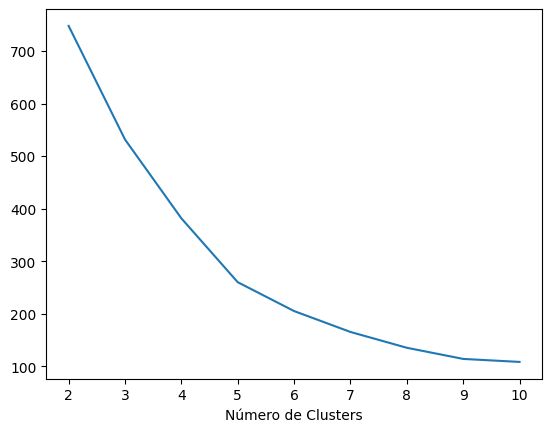

In [9]:
# Método del codo
data = df2_t
metrica = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init='auto')
    kmeans.fit(data)
    metrica.append(kmeans.inertia_)

plt.plot(range(2, 11), metrica)
plt.xlabel('Número de Clusters')
plt.show()

Para este conjunto de datos el método del codo no proporciona una opción clara. Por lo tanto, es necesario aplicar otra metodología para determinar el número óptimo de clusters.

In [10]:
# Coeficiente de silueta
data = df2_t
puntajes = []
for k in range(2, 11):
  kmeans = KMeans(n_clusters=k, n_init='auto')
  labels = kmeans.fit_predict(data)
  silhouette_avg = silhouette_score(data, labels)
  puntajes.append(silhouette_avg)
mejor_k = 2 + puntajes.index(max(puntajes))
mejor_k

2

De acuerdo con el coeficiente de silueta, el número óptimo de clusters para este conjunto de datos es: dos **(2)**.

6.2 Aplicar el algoritmo de clusterización:

In [11]:
kmeans = KMeans(n_clusters = 2, n_init='auto')
df2['Cluster'] = kmeans.fit_predict(df2_t)
df2

,Return std,Daily return range,Return mad,Cluster
0,1.740138,13.614967,1.262802,1
1,2.814473,23.807274,1.813256,0
2,2.501026,18.280372,1.825959,0
3,1.526074,11.350659,1.092042,1
4,1.090518,6.205312,0.831182,1
...,...,...,...,...
484,0.975042,6.591039,0.743252,1
485,1.186024,7.242758,0.887111,1
486,2.184484,17.940971,1.568966,0
487,2.089137,11.083029,1.613575,0


**REDUCCIÓN DE DIMENSIONALIDAD PARA VISUALIZACIÓN**

7.1. Reducir la dimensionalidad:

In [12]:
pca = PCA(n_components = 2)
dfPca = pca.fit_transform(df2_t)
dfPca = pd.DataFrame(dfPca, columns=['PCA1', 'PCA2'])
dfPca['Cluster'] = kmeans.fit_predict(df2_t)
dfPca

,PCA1,PCA2,Cluster
0,0.328604,-0.016629,0
1,2.782372,0.169558,1
2,2.081259,-0.410760,1
3,-0.256219,0.007567,0
4,-1.379756,-0.125250,0
...,...,...,...
484,-1.561337,0.057826,0
485,-1.142266,-0.104261,0
486,1.451564,-0.039150,1
487,0.875568,-0.840430,1


**VISUALIZACIÓN DE LOS RESULTADOS**

8.1. Visualizar los clusters

In [13]:
chart = alt.Chart(dfPca).mark_point(size=70).encode(
    x = 'PCA1',
    y = 'PCA2',
    color = 'Cluster:N'
).properties(
    title='Clusterización empresas del S&P 500 con KMeans',
    width=450,
    height=300
)

chart.configure_legend(
    strokeColor='gray',
    fillColor='#EEEEEE',
    padding=10,
    cornerRadius=8,
    orient='top-right'
)

alt.Chart(...)

**ANÁLISIS E INTERPRETACIÓN**

Se puede observar con claridad que las empresas del clúster dos **(1)** presentan una agrupación significativamente mayor que las empresas del clúster uno **(0)**.

La mayor dispersión de las empresas del clúster uno, directamente relacionada con una amplia propagación de los indicadores de volatilidad, podría representar un grado de inversión de mayor riesgo. Todo lo contrario ocurre con las empresas del clúster dos, lo que da a entender un menor riesgo de inversión.